In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Bidirectional, Concatenate, Input

from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report

from tensorflow.keras.models import Model

from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report


In [2]:
#read data
train = pd.read_csv('./train.csv', encoding='ISO-8859-1')

In [3]:
train.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [4]:
test = pd.read_csv('./test.csv', encoding='ISO-8859-1')

In [9]:
test.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


In [11]:
df_train=pd.DataFrame(train)

In [13]:
df_train.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [15]:
df_test=pd.DataFrame(test)

In [17]:
df_test.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0


In [19]:
# remove unwanted columns
df_train.drop(['Density (P/Km²)', 'Land Area (Km²)', 'Population -2020', 'Country', 'Age of User', 'Time of Tweet', 'textID', 'selected_text'], axis=1, inplace=True)
df_test.drop(['Density (P/Km²)', 'Land Area (Km²)', 'Population -2020', 'Country', 'Age of User', 'Time of Tweet', 'textID'],  axis=1, inplace=True)

In [21]:
df_train.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [23]:
df_test.head()

,text,sentiment
0,Last session of the day http://twitpic.com/67ezh,neutral
1,Shanghai is also really exciting (precisely -...,positive
2,"Recession hit Veronique Branquinho, she has to...",negative
3,happy bday!,positive
4,http://twitpic.com/4w75p - I like it!!,positive


In [25]:
# cleaning data
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\avnis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
print(stop_words)

{'her', 'in', 'weren', "isn't", 'mustn', 'these', "you're", 'you', 'hasn', 'why', "she's", "it's", 'for', "aren't", 'while', "shouldn't", 'hers', 'of', 'such', "won't", 'y', 'from', 'themselves', 'at', 'be', 'and', 'isn', 'his', 'been', "hadn't", "weren't", 'only', 'yourself', 'some', 'this', 'have', 'won', 'yourselves', 'ours', 'to', 'few', 'were', 'under', "mightn't", "you've", 'he', 'into', 'its', 'on', 'most', 'am', 'them', 'wouldn', 'own', 'down', 'ain', 'did', 'an', 'here', 'too', 'doesn', 'just', 'o', 'before', 'if', "you'll", 'but', 'that', 'than', 'didn', 'my', 's', 'more', "shan't", 'the', 'wasn', 'further', 'can', 'when', 'ma', 'their', 'about', 'nor', 'm', "didn't", 'him', 'through', 'so', "couldn't", "should've", 'needn', 'until', 'each', 'our', 'has', 'both', "you'd", 'between', 'himself', 'shan', 'me', 'not', 'ourselves', 'how', "wouldn't", 'herself', 'above', 'or', 'i', 'is', 'had', "hasn't", 'now', 'are', "that'll", 'once', 'd', 'aren', "mustn't", 'it', 'a', 'should', 

In [29]:
df_train.isnull().sum()


text         1
sentiment    0
dtype: int64

In [31]:
null_rows = df_train[df_train.isnull().any(axis=1)]
print(null_rows)

    text sentiment
314  NaN   neutral


In [33]:
len(df_train)


27481

In [35]:
 df_train.iloc[314]

text             NaN
sentiment    neutral
Name: 314, dtype: object

In [37]:
df_train.dropna(inplace=True)

In [39]:
df_train.isnull().sum()

text         0
sentiment    0
dtype: int64

In [41]:
null_rows=df_train[df_train.isnull().any(axis=1)]
print(null_rows)

Empty DataFrame
Columns: [text, sentiment]
Index: []


In [43]:
df_test.dropna(inplace=True)

In [45]:
df_test.isnull().sum()

text         0
sentiment    0
dtype: int64

In [47]:
len(df_test)

3534

In [49]:
# preprocess the text

def preprocess_text(text):
    if not isinstance(text, str):
        return ''

    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text=text.lower()
    tokens = [word for word in text.split() if word not in stop_words]
    return ' '.join(tokens)


# Ensure the 'text' column is of string type
df_train['text'] = df_train['text'].astype(str)
df_test['text'] = df_test['text'].astype(str)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [51]:
print(df_train.head())

                                       text sentiment
0                        id responded going   neutral
1                   sooo sad miss san diego  negative
2                             boss bullying  negative
3                     interview leave alone  negative
4  sons couldnt put releases already bought  negative


In [53]:
# tokenization
tokenizer=Tokenizer(num_words=2000)
tokenizer.fit_on_texts(df_train['text'].values)
X = tokenizer.texts_to_sequences(df_train['text'])

X = pad_sequences(X, maxlen=100)

y = pd.get_dummies(df_train['sentiment']).values

tokenizer.fit_on_texts(df_test['text'])

X_test_data = tokenizer.texts_to_sequences(df_test['text'])

X_test_data = pad_sequences(X_test_data, maxlen=100)

y_test_data = pd.get_dummies(df_test['sentiment']).values

In [72]:
# mLSTM Model

# Sample data shapes

num_samples = 1000          # Number of samples

max_text_length = 100        # Max length for text sequences

num_features_text = 128     # Features for text data (e.g., embedding size)



text_input = Input(shape=(max_text_length,), name='text_input')
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128)(text_input)
text_lstm = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
text_lstm = Dropout(0.3)(text_lstm)
text_lstm = Bidirectional(LSTM(32))(text_lstm)
text_lstm = Dense(64, activation='relu')(text_lstm)
text_lstm = Dropout(0.5)(text_lstm)

output = Dense(3, activation='softmax')(text_lstm)



# Define the model

model = Model(inputs=text_input, outputs=output)



# Compile the model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [76]:
#train model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience=3, factor=0.5, min_lr=0.00001)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

history = model.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_reduction])

Epoch 1/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.5029 - loss: 0.9769 - val_accuracy: 0.6986 - val_loss: 0.7250 - learning_rate: 0.0010
Epoch 2/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 35s 58ms/step - accuracy: 0.7266 - loss: 0.6896 - val_accuracy: 0.7057 - val_loss: 0.7178 - learning_rate: 0.0010
Epoch 3/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - accuracy: 0.7528 - loss: 0.6344 - val_accuracy: 0.7091 - val_loss: 0.7025 - learning_rate: 0.0010
Epoch 4/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - accuracy: 0.7718 - loss: 0.5847 - val_accuracy: 0.7048 - val_loss: 0.7239 - learning_rate: 0.0010
Epoch 5/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 35s 58ms/step - accuracy: 0.7906 - loss: 0.5505 - val_accuracy: 0.7005 - val_loss: 0.7562 - learning_rate: 0.0010
Epoch 6/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 37s 61ms/step - accuracy: 0.8089 - loss: 0.4961 - val_accuracy: 0.6880 - val_loss: 0.8354 - learning_rate: 0.0010
Epoch 7/50
602/602 ━━━━━━━━━━━━━━━━━━━━ 38s 63ms/step - accuracy: 0.8362 - l

In [78]:
#evaluate model
#Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(X_test, y_test)
print(f"Validation Loss:{val_loss:.4f}")
print(f"Validation accuracy:{val_accuracy*100: .2f}%")

258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7113 - loss: 0.6987
Validation Loss:0.7025
Validation accuracy: 70.91%


In [80]:
#make Prediction on validation data
y_pred = model.predict(X_test_data)

#If its a classification task , you might want to convert softmax probabilities to class labels:

y_pred_class = np.argmax(y_pred, axis=1)
y_true_class = np.argmax(y_test_data, axis = 1)

#Compare prediction with actual labels

print(f"Predictions:{y_pred_class[:10]} ")
print(f"True Labels:{y_true_class[:10]} ")

111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Predictions:[2 1 1 2 1 2 1 2 2 1] 
True Labels:[1 2 0 2 2 2 0 0 1 1] 


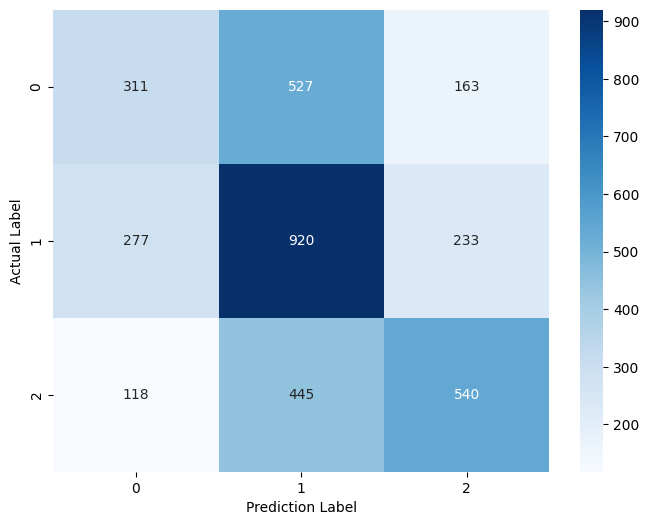

In [82]:
#Create confusion matrix 
conf_matrix = confusion_matrix(y_true_class, y_pred_class)

#Visualize the confusion matrix

plt.figure(figsize = (8, 6))

sns.heatmap(conf_matrix, annot=True, fmt = "d", cmap = "Blues")

plt.ylabel('Actual Label')
plt.xlabel('Prediction Label')

plt.show()

In [84]:
#Print classification report
print(classification_report(y_true_class, y_pred_class))

              precision    recall  f1-score   support

           0       0.44      0.31      0.36      1001
           1       0.49      0.64      0.55      1430
           2       0.58      0.49      0.53      1103

    accuracy                           0.50      3534
   macro avg       0.50      0.48      0.48      3534
weighted avg       0.50      0.50      0.49      3534



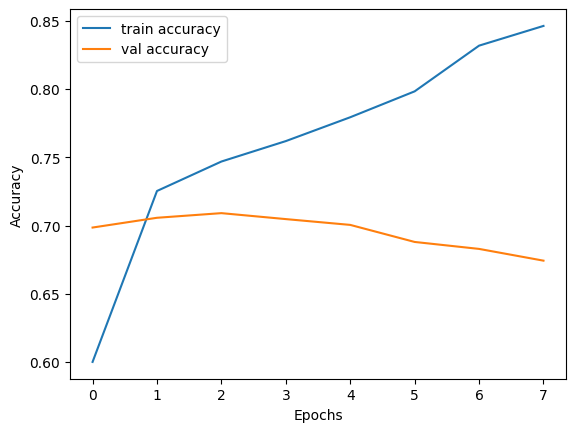

In [86]:
#plot accuracy
plt.plot(history.history['accuracy'], label='train accuracy')

plt.plot(history.history['val_accuracy'], label='val accuracy')

plt.xlabel('Epochs')

plt.ylabel('Accuracy')

plt.legend()
plt.show()